# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1  Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [ ]:
p1 = 0.8
p2 = 0.2

H_p1_p2 = -(p1*np.log(p1) + p2*np.log(p2))
round(H_p1_p2, 2)

0.5

**Задание 1.2 ** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [ ]:
p1 = 0.8
p2 = 0.2

H_rm = p1*(1 - p1) + p2*(1 - p2)
H_rl = 1*(1 - 1) + 0*(1 - 0)
H_rr = 0*(1 - 0) + 1*(1 - 1)
Q = H_rm - p1*H_rl - p2*H_rr
round(Q, 2)

0.32

**Задание 1.3 ** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [ ]:
values = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]

avg= sum(values)/len(values)

avg

40.6

## Часть 2: Решающие деревья

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [ ]:
import numpy as np
import pandas as pd
from typing import Union, Tuple

def calc_gini(y: np.ndarray) -> float:
    _, counts = np.unique(y, return_counts=True)
    p = counts / counts.sum()
    return 1 - np.sum(p ** 2)

def calculate_variance(y: np.ndarray) -> float:
    return np.var(y)

def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:

    if isinstance(feature_vector, pd.DataFrame):
        feature_vector = feature_vector.values.flatten()
    if isinstance(target_vector, pd.Series):
        target_vector = target_vector.values

    sorted_indices = np.argsort(feature_vector)
    feature_vector_sorted = feature_vector[sorted_indices]
    target_vector_sorted = target_vector[sorted_indices]

    if feature_type == "real":
        unique_values = np.unique(feature_vector_sorted)
        if len(unique_values) == 1:
            return np.array([]), np.array([]), None, None

        thresholds = (unique_values[:-1] + unique_values[1:]) / 2
        best_impurity = float('inf')
        best_threshold = None

        impurities = []

        for threshold in thresholds:
            left_mask = feature_vector_sorted < threshold
            right_mask = ~left_mask

            if task == "classification":
                left_impurity = calc_gini(target_vector_sorted[left_mask])
                right_impurity = calc_gini(target_vector_sorted[right_mask])
            else:
                left_impurity = calculate_variance(target_vector_sorted[left_mask])
                right_impurity = calculate_variance(target_vector_sorted[right_mask])

            left_weight = np.sum(left_mask) / len(feature_vector)
            right_weight = np.sum(right_mask) / len(feature_vector)
            total_impurity = left_weight * left_impurity + right_weight * right_impurity

            impurities.append(total_impurity)

            if total_impurity < best_impurity:
                best_impurity = total_impurity
                best_threshold = threshold

        return thresholds, np.array(impurities), best_threshold, best_impurity

    elif feature_type == "categorical":
        unique_values = np.unique(feature_vector_sorted)
        best_impurity = float('inf')
        best_threshold = None

        impurities = []

        for value in unique_values:
            left_mask = feature_vector_sorted == value
            right_mask = ~left_mask

            if task == "classification":
                left_impurity = calc_gini(target_vector_sorted[left_mask])
                right_impurity = calc_gini(target_vector_sorted[right_mask])
            else:
                left_impurity = calculate_variance(target_vector_sorted[left_mask])
                right_impurity = calculate_variance(target_vector_sorted[right_mask])

            left_weight = np.sum(left_mask) / len(feature_vector)
            right_weight = np.sum(right_mask) / len(feature_vector)
            total_impurity = left_weight * left_impurity + right_weight * right_impurity

            impurities.append(total_impurity)

            if total_impurity < best_impurity:
                best_impurity = total_impurity
                best_threshold = value

        return unique_values, np.array(impurities), best_threshold, best_impurity

    return np.array([]), np.array([]), None, None


Эту функцию можно протестировать на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

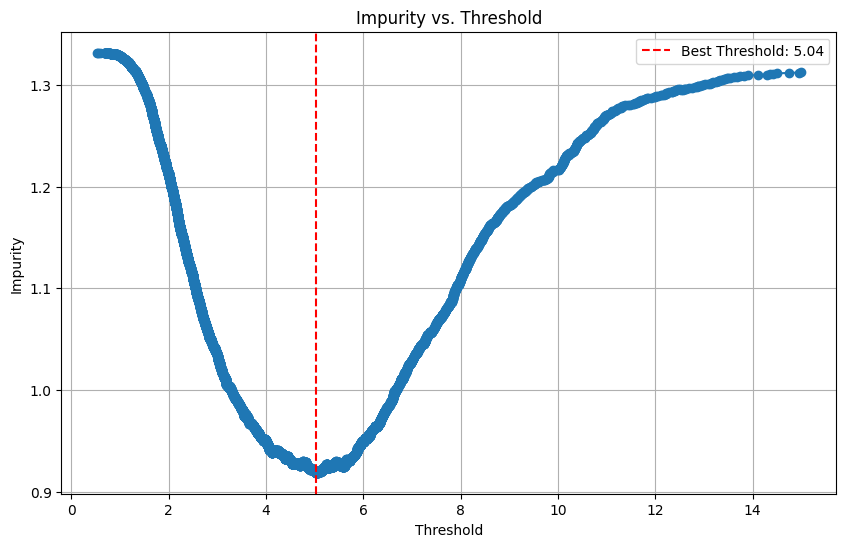

In [ ]:
feature_vector = X["MedInc"].values
target_vector = y

thresholds, impurities, best_threshold, best_impurity = find_best_split(
    feature_vector, target_vector, task="regression", feature_type="real"
)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, impurities, marker='o')
plt.axvline(best_threshold, color='r', linestyle='--', label=f'Best Threshold: {best_threshold:.2f}')
plt.title(f'Impurity vs. Threshold')
plt.xlabel('Threshold')
plt.ylabel('Impurity')
plt.legend()
plt.grid(True)
plt.show()

Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [ ]:
print(best_threshold)
print(best_impurity)

5.03515
0.9187989138801309


**Задание 2.2** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        if node["type"] == "terminal":
            return node["class"]

        if self._feature_types[node["feature_split"]] == "real":
            if x[node["feature_split"]] < node["threshold"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        elif self._feature_types[node["feature_split"]] == "categorical":
            if x[node["feature_split"]] == node["category_split"]:
                return self._predict_node(x, node["left_child"])
            else:
                return self._predict_node(x, node["right_child"])
        else:
            raise ValueError

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 ** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

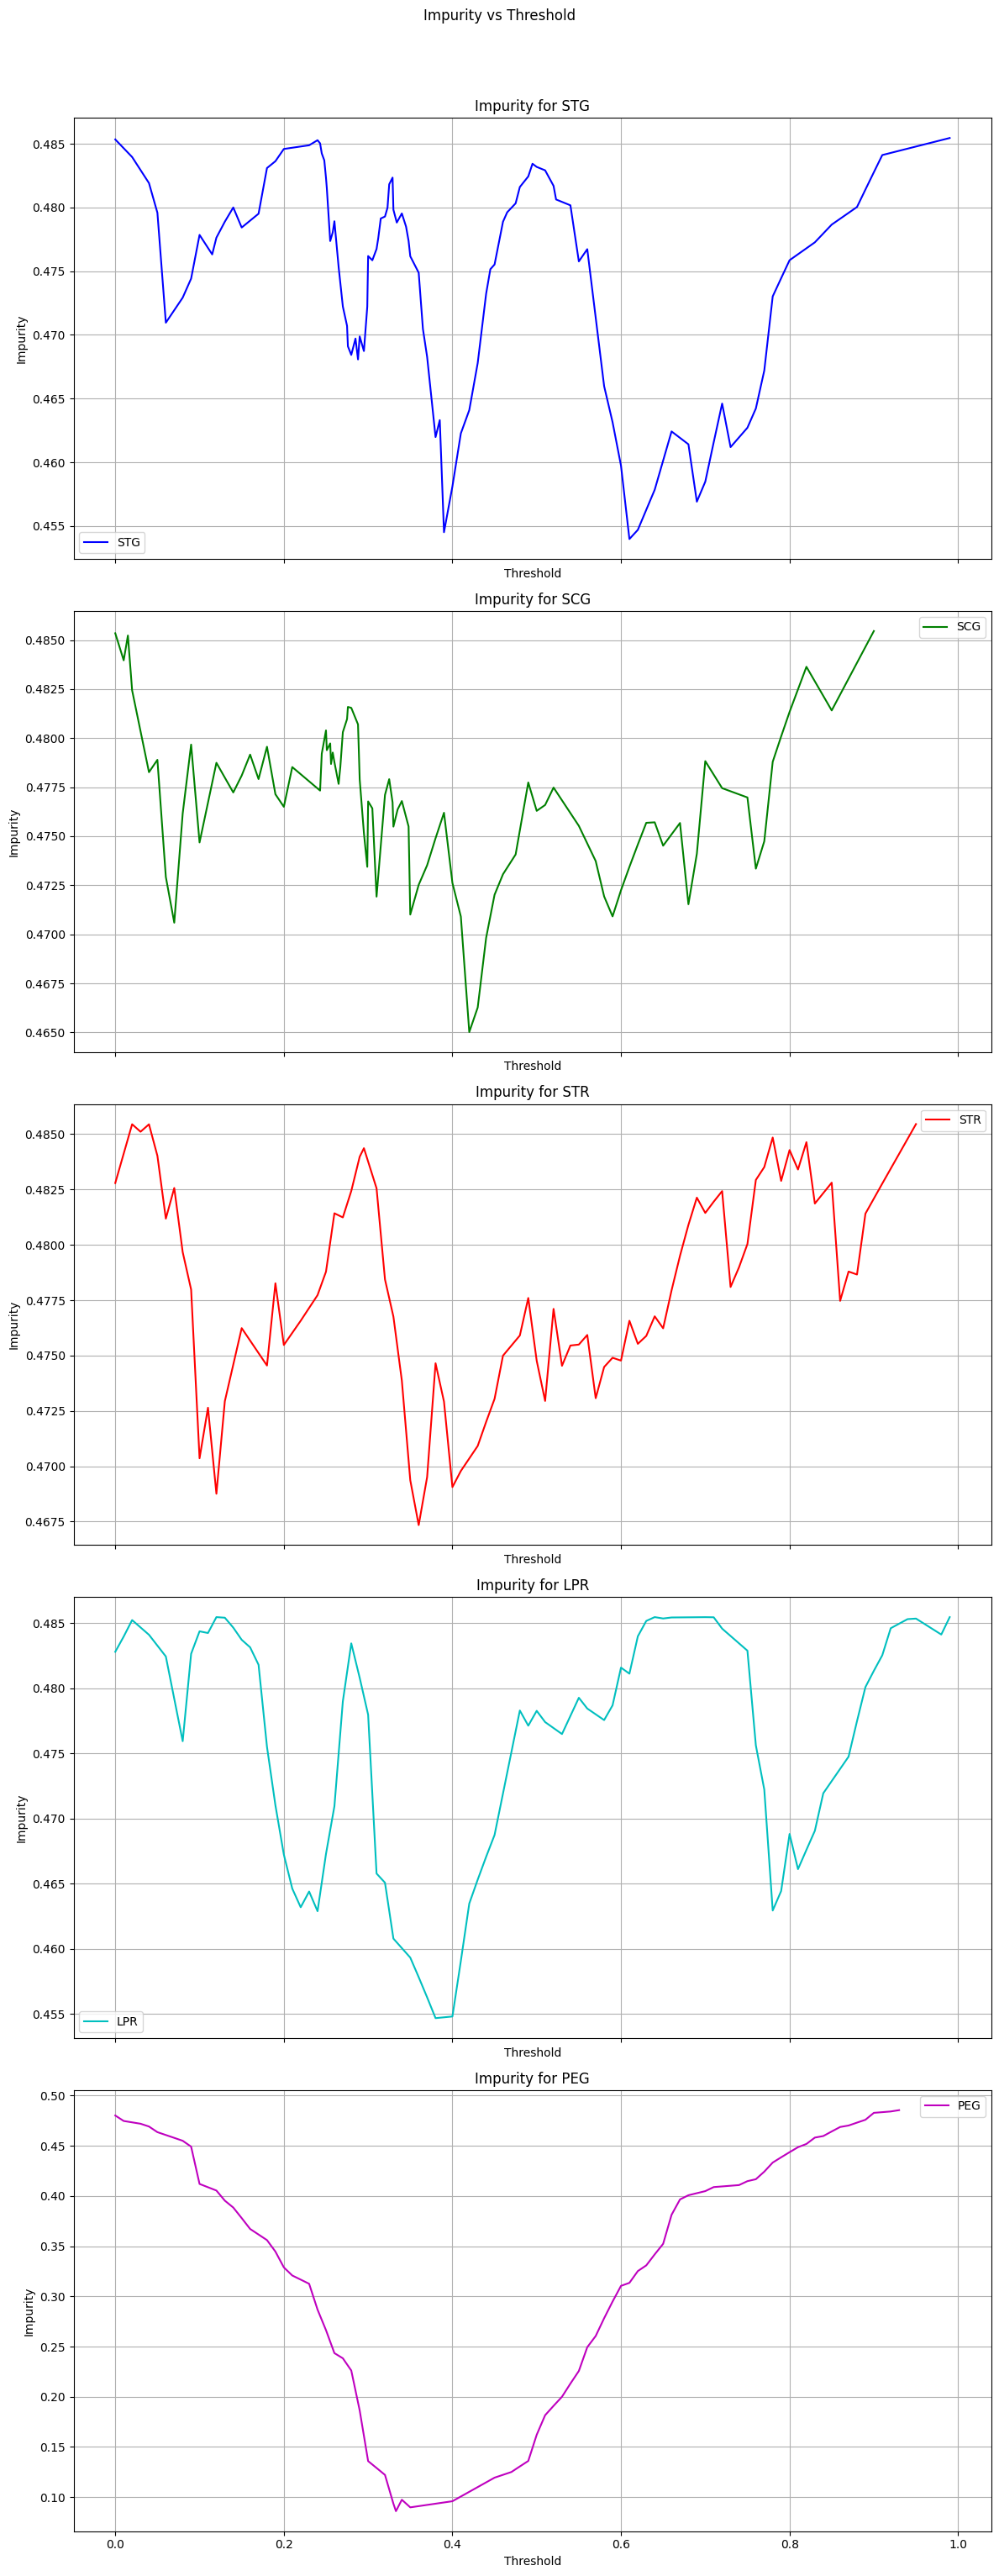

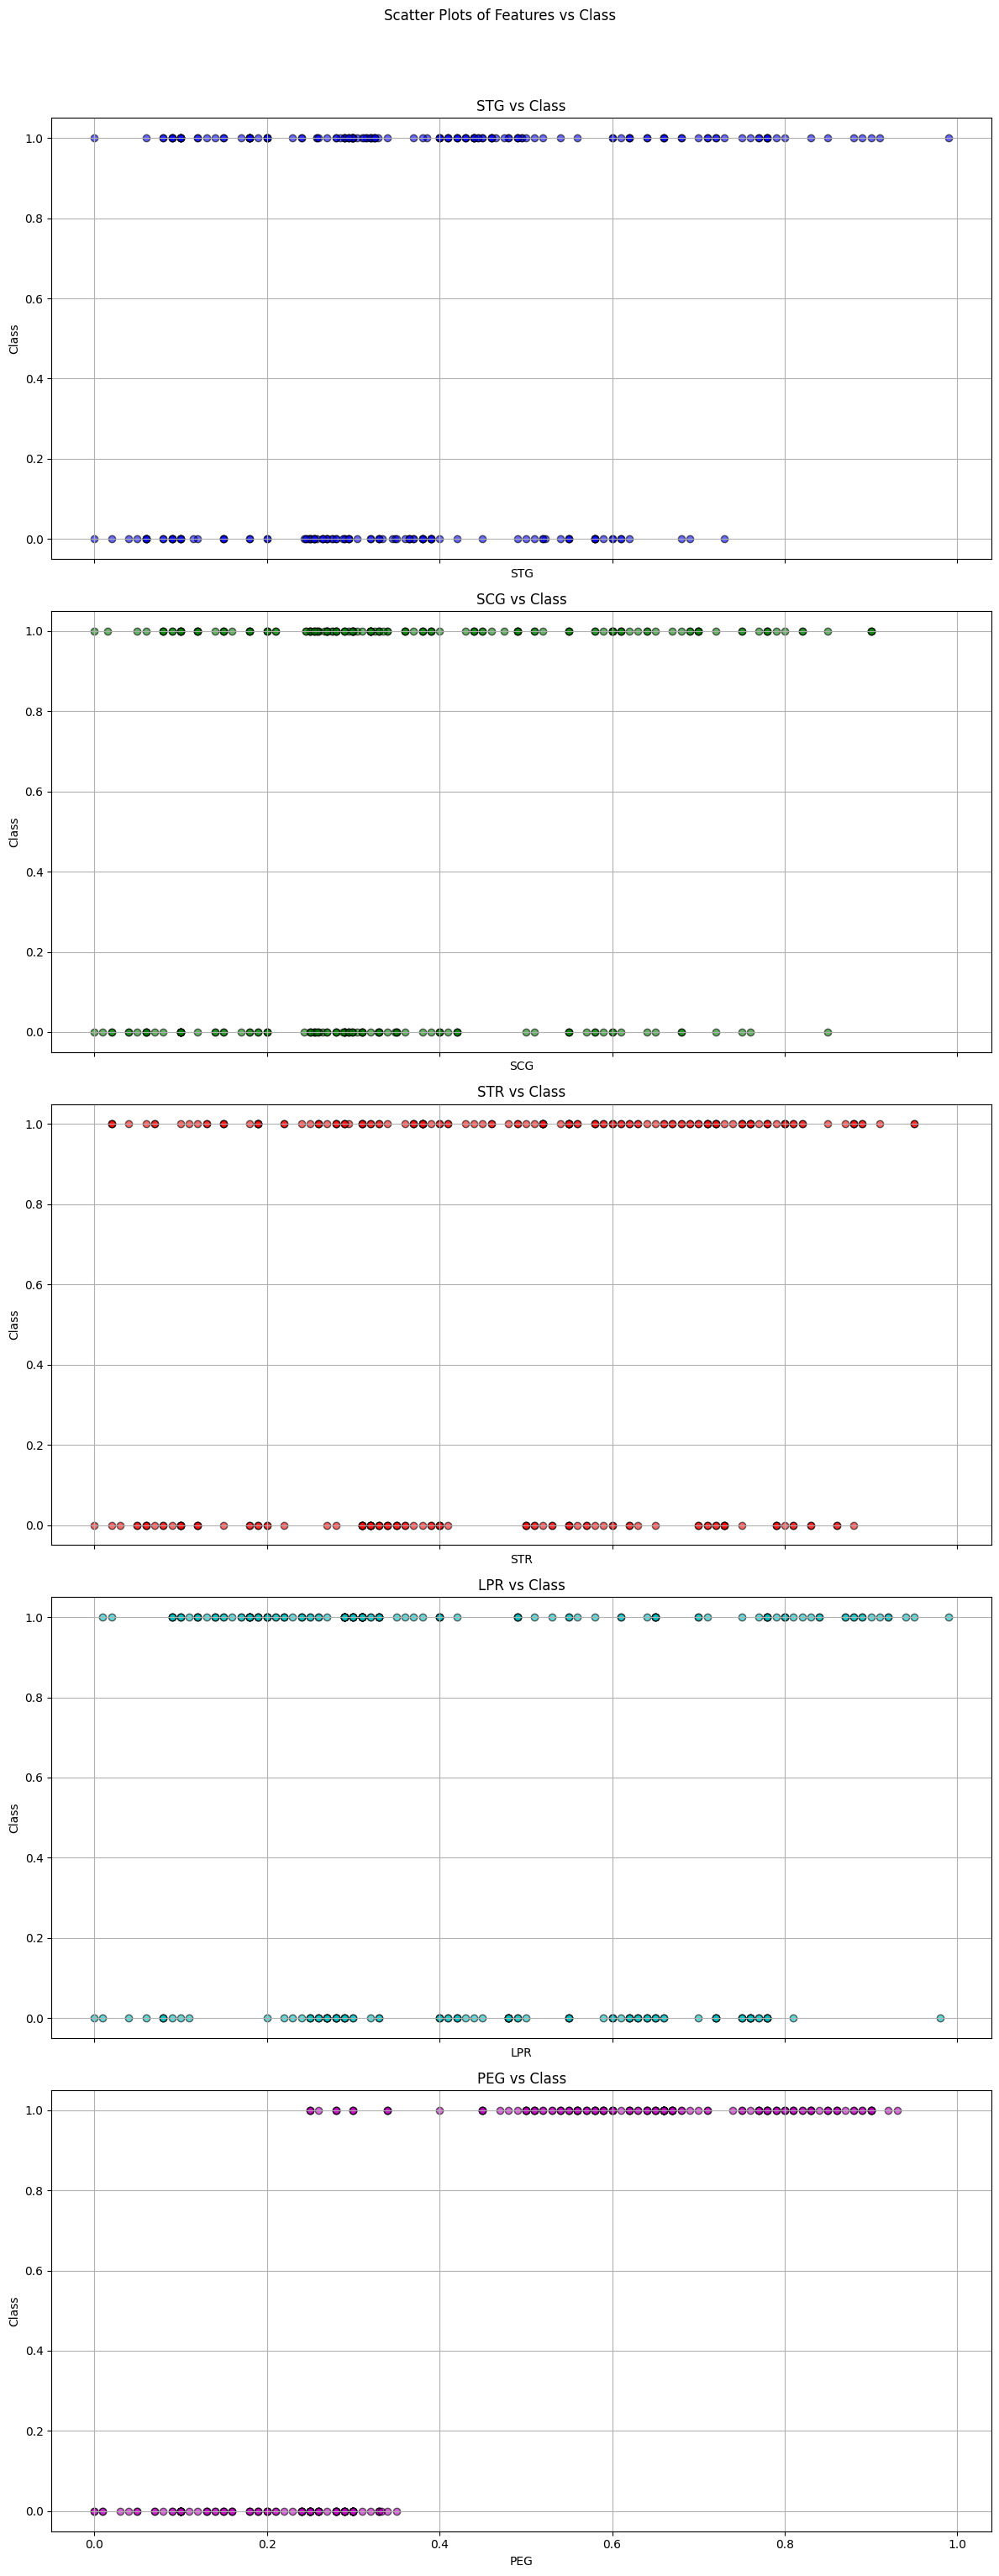

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def calc_gini(y):
    _, counts = np.unique(y, return_counts=True)
    probabilities = counts / counts.sum()
    return 1 - np.sum(probabilities ** 2)

def compute_gini_for_thresholds(feature_vector, target_vector):
    thresholds = np.unique(feature_vector)
    ginis = np.zeros(len(thresholds))

    for j, threshold in enumerate(thresholds):
        left_mask = feature_vector <= threshold
        right_mask = feature_vector > threshold

        left_gini = calc_gini(target_vector[left_mask])
        right_gini = calc_gini(target_vector[right_mask])

        ginis[j] = (len(target_vector[left_mask]) / len(target_vector) * left_gini) + (len(target_vector[right_mask]) / len(target_vector) * right_gini)

    return thresholds, ginis

def plot_gini_impurity(X, y, feature_names):
    fig, axes = plt.subplots(len(feature_names), 1, figsize=(12, 6 * len(feature_names)), sharex=True)

    colors = ['b', 'g', 'r', 'c', 'm']

    for i, (feature_name, color) in enumerate(zip(feature_names, colors)):
        feature_vector = X[:, i]
        thresholds, ginis = compute_gini_for_thresholds(feature_vector, y)

        axes[i].plot(thresholds, ginis, label=feature_name, color=color)
        axes[i].set_xlabel('Threshold')
        axes[i].set_ylabel('Impurity')
        axes[i].set_title(f'Impurity for {feature_name}')
        axes[i].legend()
        axes[i].grid(True)

    plt.suptitle('Impurity vs Threshold', y=1.02)
    plt.tight_layout()
    plt.show()

def plot_scatter_features(X, y, feature_names):
    fig, axes = plt.subplots(len(feature_names), 1, figsize=(12, 6 * len(feature_names)), sharex=True)

    colors = ['b', 'g', 'r', 'c', 'm']

    for i, (feature_name, color) in enumerate(zip(feature_names, colors)):
        axes[i].scatter(X[:, i], y, alpha=0.6, color=color, edgecolor='k')
        axes[i].set_xlabel(feature_name)
        axes[i].set_ylabel('Class')
        axes[i].set_title(f'{feature_name} vs Class')
        axes[i].grid(True)

    plt.suptitle('Scatter Plots of Features vs Class', y=1.02)
    plt.tight_layout()
    plt.show()

students = pd.read_csv('students.csv')

X = students.iloc[:, 1:-1].values
y = students.iloc[:, -1].values
feature_names = students.columns[1:-1]

plot_gini_impurity(X, y, feature_names)

plot_scatter_features(X, y, feature_names)



Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

нужно производить деление по peg. да, согласуется. вид кривой для хороших признаков похож на параболу. они очень сложные и у них много локальных минимумов


## Часть 3: Бэггинг и случайный лес

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

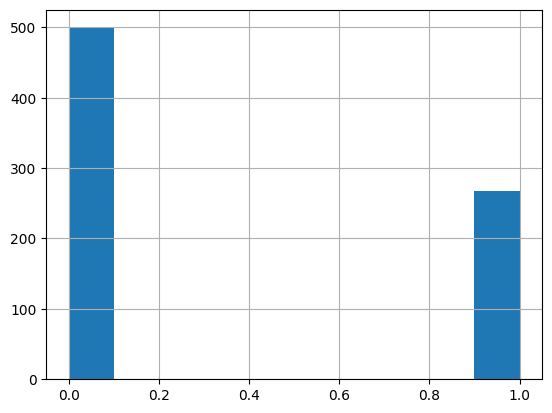

In [ ]:
data['Outcome'].hist()
plt.show()

**Задание 3.1** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [ ]:
X = data.drop(columns=['Outcome'])
y = data['Outcome']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

X_train_train, X_val, y_train_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42, stratify=y_train)


print(X_train_train.shape)
print(X_val.shape)
print(X_test.shape)

(375, 8)
(162, 8)
(231, 8)


**Задание 3.2** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
from sklearn.metrics import f1_score

max_depth_values = [3, 5, 7, 9]
min_samples_leaf_values = [1, 3, 5, 7]

best_f1 = 0
best_max_depth = None
best_min_samples_leaf = None

for max_depth in max_depth_values:
    for min_samples_leaf in min_samples_leaf_values:
        tree = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
        tree.fit(X_train_train, y_train_train)

        y_pred_val = tree.predict(X_val)
        f1 = f1_score(y_val, y_pred_val)

        if f1 > best_f1:
            best_f1 = f1
            best_max_depth = max_depth
            best_min_samples_leaf = min_samples_leaf

print(f"max_depth: {best_max_depth}")
print(f"min_samples_leaf: {best_min_samples_leaf}")

best_tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
best_tree.fit(X_train, y_train)

y_pred_test = best_tree.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred_test),2)
precision = precision_score(y_test, y_pred_test)
recall = round(recall_score(y_test, y_pred_test),2)
auc_roc = round(roc_auc_score(y_test, y_pred_test),2)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc_roc}")

max_depth: 5
min_samples_leaf: 1
Accuracy: 0.77
Precision: 0.8
Recall: 0.44
AUC-ROC: 0.69


**Задание 3.3** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [ ]:
bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

y_pred_test = bagging_clf.predict(X_test)
accuracy = round(accuracy_score(y_test, y_pred_test),2)
precision = round(precision_score(y_test, y_pred_test),2)
recall = round(recall_score(y_test, y_pred_test),2)
auc_roc = round(roc_auc_score(y_test, y_pred_test),2)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC-ROC: {auc_roc}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.75
Precision: 0.69
Recall: 0.54
AUC-ROC: 0.7


**Задание 3.4** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid_rf = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}
grid_search_rf = GridSearchCV(RandomForestClassifier(n_estimators=50, random_state=42), param_grid_rf, scoring='f1', cv=5)
grid_search_rf.fit(X_train, y_train)
best_params = grid_search_rf.best_params_

best_tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
best_tree.fit(X_train, y_train)

bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=42)
bagging_clf.fit(X_train, y_train)

best_rf = RandomForestClassifier(n_estimators=50, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)
best_rf.fit(X_train, y_train)

def get_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    return {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'AUC-ROC': roc_auc_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }

metrics_dt = get_metrics(best_tree, X_test, y_test)
metrics_bagging = get_metrics(bagging_clf, X_test, y_test)
metrics_rf = get_metrics(best_rf, X_test, y_test)

results = pd.DataFrame({
    'Decision Tree': metrics_dt,
    'Bagging Classifier': metrics_bagging,
    'Random Forest': metrics_rf
})

print(results)


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


           Decision Tree  Bagging Classifier  Random Forest
Accuracy        0.766234            0.753247       0.761905
Precision       0.800000            0.687500       0.696970
Recall          0.444444            0.543210       0.567901
AUC-ROC         0.692222            0.704938       0.717284
F1 Score        0.571429            0.606897       0.625850


random forest можно считать лучшей моделью

**Задание 3.5** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

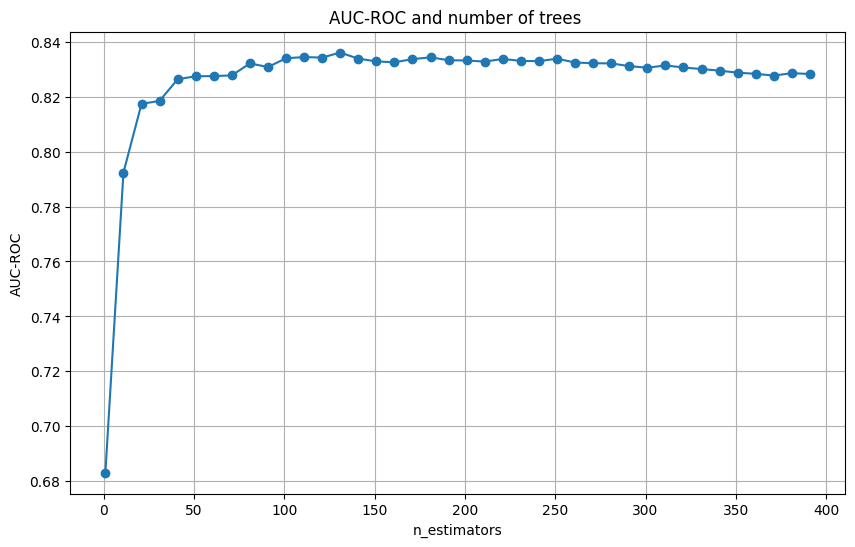

In [ ]:
n_estimators_range = range(1, 401, 10)

auc_scores = []

for n_estimators in n_estimators_range:
    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)
    rf.fit(X_train, y_train)
    y_pred_proba = rf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_pred_proba)
    auc_scores.append(auc)

plt.figure(figsize=(10, 6))
plt.plot(n_estimators_range, auc_scores, marker='o', linestyle='-')
plt.xlabel('n_estimators')
plt.ylabel('AUC-ROC')
plt.title('AUC-ROC and number of trees ')
plt.grid(True)
plt.show()

**Задание 3.6** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?(содержание глюкозы)

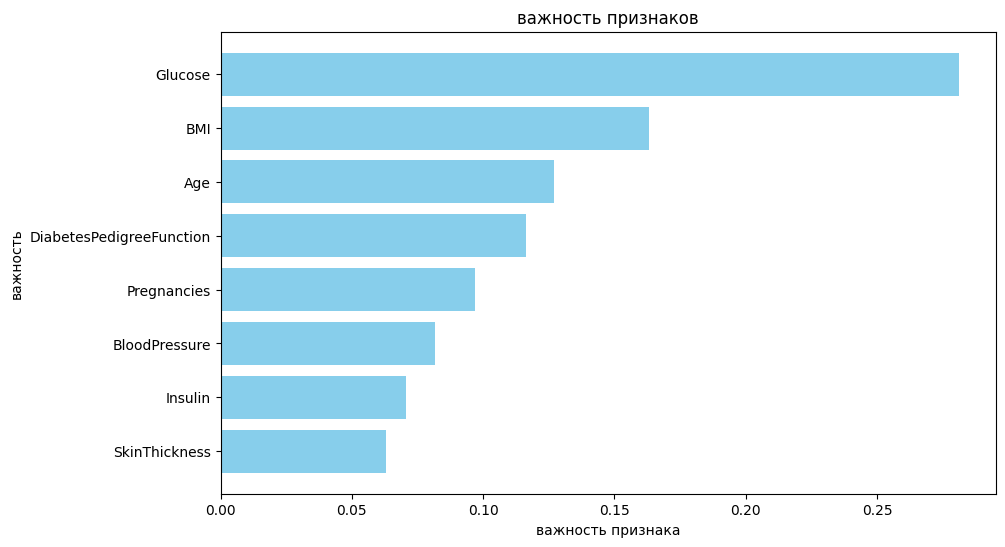

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

best_rf = RandomForestClassifier(n_estimators=50, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'], random_state=42)
best_rf.fit(X_train, y_train)

feature_importances = best_rf.feature_importances_

feature_names = data.columns[:-1]

feature_importances_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'], feature_importances_df['Importance'], color='skyblue')
plt.xlabel('важность признака')
plt.ylabel('важность')
plt.title('важность признаков')
plt.gca().invert_yaxis()
plt.show()